In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [ ]:
import random

In [ ]:
from IPython.display import clear_output
import torch.optim as optim

In [ ]:
indexes = list(range(160))

In [ ]:
random.shuffle(indexes)

In [ ]:
np.save('C:/Users/MK/Nika/exp5/indexes.npy',indexes)

In [ ]:
indexes = np.load('C:/Users/MK/Nika/exp5/indexes.npy')

In [ ]:
piece_size = 64

In [ ]:
torch.cuda.is_available()

True

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=1, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 32, 64, 128, 256, 512]

        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])

        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose3d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])

        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])

        self.max_pool_2x2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.final_conv = nn.Conv3d(32, classes, kernel_size=1)

#         self.final_conv = nn.Conv3d(1, 1, kernel_size = 1, padding="same")

    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv

    def forward(self, x):
        concat_layers = []

        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)

        concat_layers = concat_layers[::-1]

        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])

            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)

        x = self.final_conv(x)

        return x

In [ ]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3)
    return dice

In [ ]:
def run_epoch(model, size, train, target, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for i in range(size):
        if is_training:
            optimizer.zero_grad()


        x = train[i].unsqueeze(0).unsqueeze(0).to('cuda')
        y = target[:, i].unsqueeze(0).to('cuda')

        out = model(x)
        loss = criterion(out, y)

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item())

    return epoch_loss/size

In [ ]:
def plot_block_with_mask(blocks, blocks_masks, num = 30, y = 30):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(blocks[num][:,  y])
    f.add_subplot(1,2, 2)
    plt.imshow(blocks_masks[num][2, :, y])
    plt.show(block=True)

In [ ]:
indexes = list(range(128))
random.shuffle(indexes)

In [ ]:
np.save('C:/Users/MK/Nika/exp5/indexes.npy',indexes)

In [ ]:
indexes = np.load('C:/Users/MK/Nika/exp5/indexes.npy')

In [ ]:
np.shape(indexes)

(128,)

## Новый эксперимент с большим кол-вом эпох

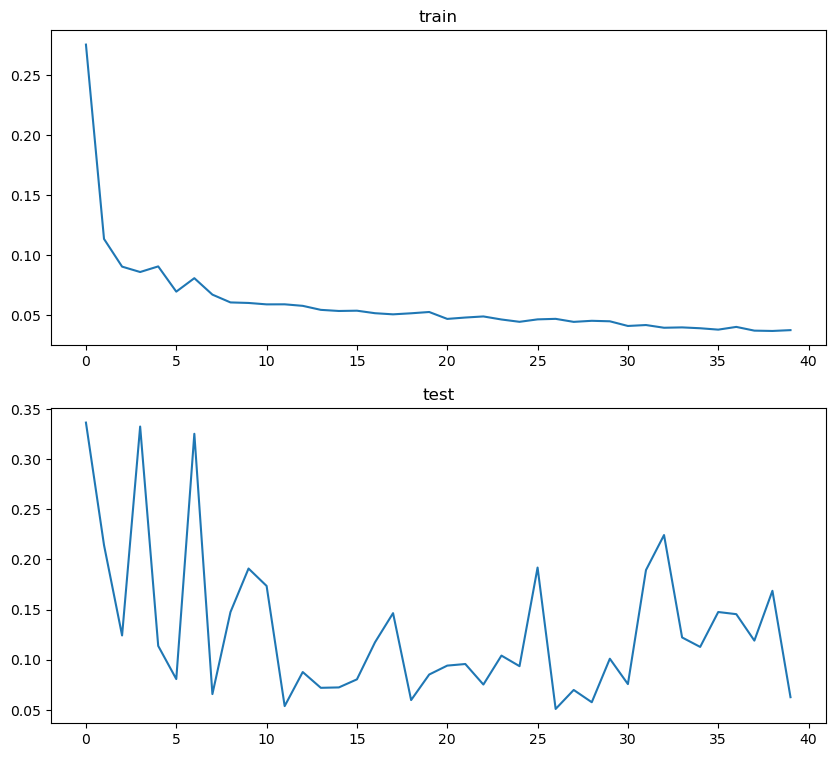

Epoch[40/40] | loss train:0.037511, test:0.062748
CPU times: total: 3h 55min 56s
Wall time: 3h 55min 28s


In [ ]:
%%time
for cross_val in range(0,5):
    print('cross_val=', cross_val)
    train = torch.empty(128, 256, piece_size, piece_size)
    train_target = torch.empty(128, 5, 256, piece_size, piece_size)
    ind = 0
    for i in range(5):
        if i != cross_val:
            train[ind*32:32*(1+ind)] = torch.load('C:/Users/MK/Nika/Data64/finger' + str(i) + '.pt')
            train_target[ind*32:32*(1+ind)] = torch.load('C:/Users/MK/Nika/Data64/finger' + str(i) + '_blocks.pt')
            ind += 1
    test = torch.load('C:/Users/MK/Nika/Data64/finger' + str(cross_val) + '.pt')
    test_target = torch.load('C:/Users/MK/Nika/Data64/finger' + str(cross_val) + '_blocks.pt')

    train_target = train_target[indexes]
    train = train[indexes]

    plot_block_with_mask(train, train_target)

    train_target =  train_target.transpose(0, 1)
    test_target =  test_target.transpose(0, 1)

    print(test_target.size())


    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True

    model = UNET(1, 5).to('cuda')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
    lr = 0.001


    losses_train = []
    losses_test = []

    for epoch in range(40):
        print(epoch)
        loss_train = run_epoch(model, 128, train, train_target, is_training=True)
        loss_test = run_epoch(model, 32, test, test_target)
        losses_train.append(loss_train)
        losses_test.append(loss_test)

        clear_output(True)

        fig = plt.figure(figsize=(10, 9))

        ax_1 = fig.add_subplot(2, 1, 1)
        ax_2 = fig.add_subplot(2, 1, 2)

        ax_1.set_title('train')
        ax_1.plot(losses_train)
        ax_2.set_title('test')
        ax_2.plot(losses_test)

        plt.show()

        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
                  .format(epoch+1, 40, loss_train, loss_test))
    torch.save(model.state_dict(), "C:/Users/MK/Nika/exp5/hyperparameter3/unet3d" + str(cross_val))
    fig.savefig('C:/Users/MK/Nika/exp5/hyperparameter3/cross_val'+  str(cross_val) + '.png')
    np.save('C:/Users/MK/Nika/exp5/hyperparameter3/losses_train'+  str(cross_val) + '.npy',  losses_train)
    np.save('C:/Users/MK/Nika/exp5/hyperparameter3/losses_test'+  str(cross_val) + '.npy',  losses_test)

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


total_params, trainable_params = count_parameters(model)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {total_params - trainable_params}")

Total parameters: 22576933
Trainable parameters: 22576933
Non-trainable parameters: 0


# Обучение моделей на 4 эпохах

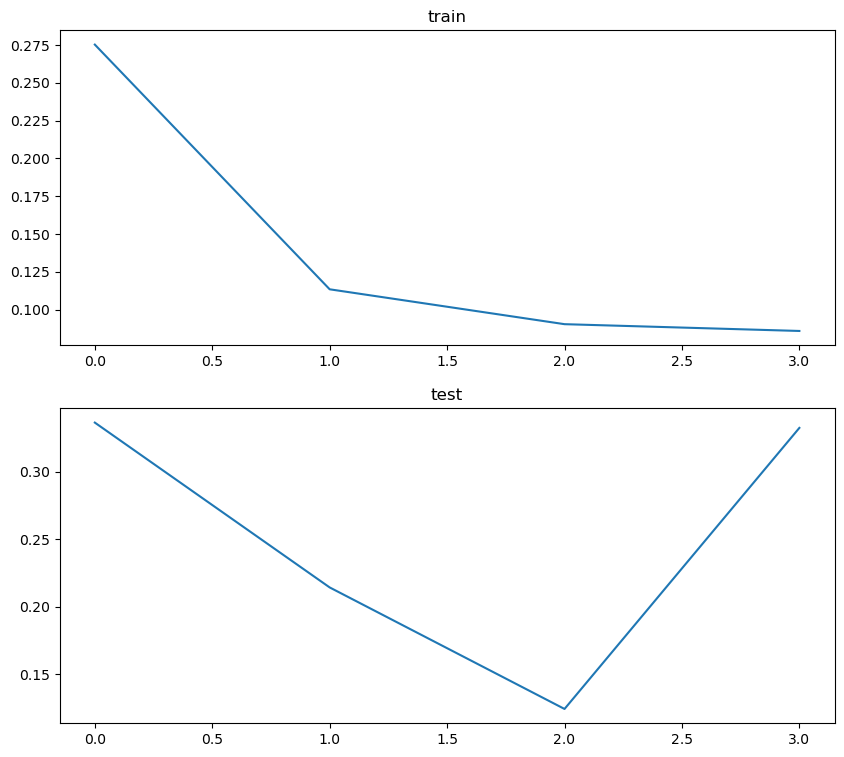

Epoch[4/4] | loss train:0.085916, test:0.332511
CPU times: total: 1h 9min 1s
Wall time: 1h 8min 52s


In [ ]:
for cross_val in range(1,5):
    print('cross_val=', cross_val)

    train = torch.empty(128, 256, piece_size, piece_size)
    train_target = torch.empty(128, 5, 256, piece_size, piece_size)
    ind = 0
    for i in range(5):
        if i != cross_val:
            train[ind*32:32*(1+ind)] = torch.load('C:/Users/MK/Nika/Data64/finger' + str(i) + '.pt')
            train_target[ind*32:32*(1+ind)] = torch.load('C:/Users/MK/Nika/Data64/finger' + str(i) + '_blocks.pt')
            ind += 1
    test = torch.load('C:/Users/MK/Nika/Data64/finger' + str(cross_val) + '.pt')
    test_target = torch.load('C:/Users/MK/Nika/Data64/finger' + str(cross_val) + '_blocks.pt')

    train_target = train_target[indexes]
    train = train[indexes]

    plot_block_with_mask(train, train_target)

    train_target =  train_target.transpose(0, 1)
    test_target =  test_target.transpose(0, 1)

    print(test_target.size())


    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True

    model = UNET(1, 5).to('cuda')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
    lr = 0.001


    losses_train = []
    losses_test = []

    for epoch in range(4):
        print(epoch)
        loss_train = run_epoch(model, 128, train, train_target, is_training=True)
        loss_test = run_epoch(model, 32, test, test_target)
        losses_train.append(loss_train)
        losses_test.append(loss_test)

        clear_output(True)

        fig = plt.figure(figsize=(10, 9))

        ax_1 = fig.add_subplot(2, 1, 1)
        ax_2 = fig.add_subplot(2, 1, 2)

        ax_1.set_title('train')
        ax_1.plot(losses_train)
        ax_2.set_title('test')
        ax_2.plot(losses_test)

        plt.show()

        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
                  .format(epoch+1, 4, loss_train, loss_test))
    torch.save(model.state_dict(), "C:/Users/MK/Nika/exp5/hyperparameter2/unet3d" + str(cross_val))
    fig.savefig('C:/Users/MK/Nika/exp5/hyperparameter2/cross_val'+  str(cross_val) + '.png')
    np.save('C:/Users/MK/Nika/exp5/hyperparameter2/losses_train'+  str(cross_val) + '.npy',  losses_train)
    np.save('C:/Users/MK/Nika/exp5/hyperparameter2/losses_test'+  str(cross_val) + '.npy',  losses_test)